# Act 3: Full Survey View

    + Use of Zenithal projections
    A "zenithal" projection of the sphere is what you get by putting a flat sheet of paper tangent to the sphere at some projection axis (ra0,dec0) and placing a light bulb along the line passing through this tangent point and the center of the sphere.  `mu` is the distance of the lightbulb from the _center_ of the sphere in units of its radius. `mu=0` is the _gnomonic_ projection that we have been using by default.  `mu>0` puts the bulb (or viewpoint) farther away and `mu>1` will shrink the edges of the sphere so they don't blow up, which is what we would like.  Note that `mu<-1` will place the viewpoint outside the sphere above the projection point, which is nice if you're e.g. showing the surface of a planet.

In [352]:
# import useful classes
from importlib import reload
import orbitdot
from orbitdot import Orbit, Dot
import timeline
from timeline import Timeline
import observer
from observer import Observer
#reload()
# astropy
import astropy
import astropy.table as tb
from astropy.wcs import WCS
import astropy.io.fits as pf
# plotting and animating
import matplotlib
from matplotlib import animation
from IPython.display import Video
from matplotlib import pyplot as pl
from matplotlib.animation import FuncAnimation
# others
import numpy as np
import reproject as rp

In [353]:
import orbitdot
from orbitdot import Orbit, Dot
import timeline
from timeline import Timeline
import observer
from observer import Observer

In [286]:
def azp_wcs(ra0=20, dec0=-35, mu=1.2, pixscale=0.1,shape=(170.,100.)):
    '''Return a WCS realizing an azimuthal projection about the 
    specified RA & DEC with specified `mu` value.  All arguments 
    given in degrees.
    `pixscale` is angular size of pixel at the pole
    `shape` is a 2-element array giving total extent of the field if an image is
    being made (using x,y convention).
    The defaults yield a nice view of the DES footprint.
    The return values are the wcs, and a tuple giving the shape
    of the (2d) resultant image field (in the y,x numpy convention).'''

    # Build the WCS as a header dictionary 
    npix1 = int(np.floor(shape[0]/pixscale))
    npix2 = int(np.floor(shape[1]/pixscale))
    h={'CTYPE1':'RA---AZP'}
    h['CTYPE2']='DEC--AZP'
    h['NAXIS']=2
    h['NAXIS1']=npix1
    h['NAXIS2']=npix2
    h['CRPIX1']=npix1/2+1
    h['CRPIX2']=npix2/2+1
    h['CRVAL1']=ra0
    h['CRVAL2']=dec0
    h['CDELT1']=pixscale
    h['CDELT2']=pixscale
    h['CUNIT1']='deg'
    h['CUNIT2']='deg'
    h['PV2_1']=mu
    return WCS(pf.Header(h)), (h['NAXIS2'],h['NAXIS1'])

In [290]:
wcs,shape = azp_wcs(ra0=20, dec0=-35, mu=1.2)

# projected mellinger image
melwcs = WCS(pf.Header.fromfile('/Users/saarahhall/Desktop/data visualization/dataa/melbig.wcs'))
rgb = pl.imread('dataa/melbig.jpg')
rgb2=[]
for c in range(3):
    # Do each color one by one, and also take a log of the
    # brightness while we're at it.
    a,f = rp.reproject_interp((rgb[:,:,c],melwcs),wcs,shape_out=shape,return_footprint=True)
    rgb2.append(a.astype(np.uint8,casting='unsafe'))
rgb2 = np.stack(rgb2)
rgb2 = np.moveaxis(rgb2,0,2)

# completely zoomed out wcs and image crop
factor = 160
finalwcs = wcs[(393-int(2.1875*factor)):(454+int(factor*3.4125)), (796-int(factor*4.975)):(905+int(factor*4.96875))]
rgb2_crop = rgb2[(393-int(2.1875*factor)):(454+int(factor*3.4125)), (796-int(factor*4.975)):(905+int(factor*4.96875))]

# DES footprint outline
ra,dec = np.loadtxt('round17-poly.txt',comments='#',unpack=True)
x,y = finalwcs.all_world2pix(ra,dec,0)

### Act 3 Scene 1
#### Zoom out to the full survey with 5 star TNOs still shown

In [288]:
fig = pl.figure(figsize=(16,9))
ax = pl.subplot(projection=wcs)
pl.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.imshow(rgb2)
ax.autoscale(False)

# Draw the footprint outline
ax.plot(x,y,color = '#A6A6B5',lw=2)
# Draw grid
ax.coords.grid(True, color='red', ls='--')
ax.coords[0].set_format_unit('deg', decimal=True)

# Draw 5 star TNOS from Act 2
IDs5 = [375, 191, 439, 205, 248]
orbs5 = [Orbit(IDs5[k]) for k in range(len(IDs5))]
color_array = ['#DAB733', '#2B6FB0', '#B0302B', '#8FB339','#7E6AB4']
for i in range(len(IDs5)):
    pixelcoords = orbs5[i].wcsPath(wcs,2013,5)[1]
    ax.autoscale(False)
    ax.plot(pixelcoords[0], pixelcoords[1], lw=2, color = color_array[i])
    orbs[i].wcsPlotDots(wcs,ax,"white",2,0.4)

frnum = 300
xdiff, ydiff = ((454 - 393)*3), (xdiff/(16/9))
# initial and final axes boundaries
i_xmin, i_xmax = 788, (i_xmin+xdiff)
i_ymin, i_ymax = 857, (i_ymin + ydiff)
f_xmin, f_xmax = -0.5, 1699.5
f_ymin, f_ymax = -0.5, 999.5

def animate(i):  
    ax.set_xlim(i_xmin - ((i_xmin - f_xmin) / frnum)*i,
                i_xmax + ((f_xmax - i_xmax) / frnum)*i)
    ax.set_ylim(i_ymin - ((i_ymin - f_ymin) / frnum)*i,
                i_ymax + ((f_ymax - i_ymax) / frnum)*i)
    ax.set_xlim(ax.get_xlim()[::-1])
anim = FuncAnimation(fig, animate,frames=frnum,interval=1,blit=False)
anim.save('a3s1.mp4', writer='ffmpeg', fps=60, dpi=80, bitrate=-1)  
Video('a3s1.mp4')

##### storing information needed for all 700+ TNOs
    ** Change interval value to 70 (Orbit, Observer class files)
    *** (in orbitdot.py file, line 153, __ * tdbspan), (observer.py line 34)
    The cell below should take a while to load

In [309]:
# load all TNO Orbits
allIDs = range(0,718)
allorbs = [Orbit(allIDs[k]) for k in range(len(allIDs))]

start = 2013
span = 6
allinfos = [allorbs[j].getPath(start,span) for j in range(len(allorbs))]
#if you hit IOPub data limit:
#--NotebookApp.iopub_data_rate_limit = 1.0e10

# all pixel coordinates for TNOs after their first detection
seencoords = [allorbs[j].wcsPath(finalwcs,start,span)[1] for j in range(len(allorbs))] 
# the frame index at which a given TNO is first seen
detindeces = [allinfos[j][7] for j in range(len(allorbs))]
clock = allinfos[0][2]
total_frnum = span*70

# colormap values and timeline
cmap = matplotlib.cm.Spectral
alltnoi = tb.Table.read('dataa/y4_tno_table.fits')
min_d = alltnoi['d'][(alltnoi['d'] < 28)][0]
norm = matplotlib.colors.Normalize(vmin=min_d, vmax=55)
tl = Timeline(start,(start+span))

### Act 3 Scene 2
#### 2013-2015

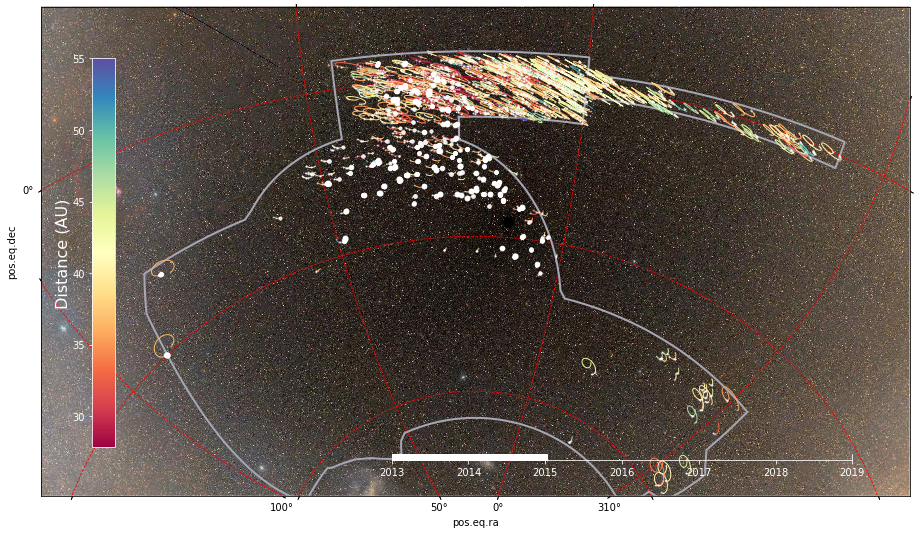

In [345]:
# Create figure and show image
fig = pl.figure(figsize=(16,9))
ax = pl.subplot(projection=finalwcs)
ax.imshow(rgb2_crop)

# Draw coordinate grid
ax.coords.grid(True, color='red', ls='--')
ax.coords[0].set_format_unit('deg', decimal=True)
ax.autoscale(False)
ax.set_xlim(ax.get_xlim()[::-1])

# Draw the footprint outline - map ra/dec to projected coords first.
ax.plot(x,y,color = '#A6A6B5',lw=2)

# colorbar in frame
cax = fig.add_axes([0.18, 0.2, 0.02, 0.6])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,norm=norm,orientation='vertical')
cb.set_label('Distance (AU)', labelpad = -60)
cb.ax.yaxis.label.set_color('white')
cb.ax.yaxis.label.set_font_properties(matplotlib.font_manager.FontProperties(size=16))
cb.ax.tick_params(axis='y', colors='white')
cb.outline.set_edgecolor('white')
cax.yaxis.set_ticks_position('left')

# plot Timeline
tl.plot(ax, 0.44,0.18)

# Automate pl.plots
points = [ax.plot([], [], '-', lw=1, color=cmap(allorbs[i].color_val))[0] for i in range(len(allorbs))] #pl.
xdata = [[] for i in range(len(allorbs))]
ydata = [[] for i in range(len(allorbs))]

# animate Orbits, Dots, and Timeline
def init():
    return points
def animate(i):
    for o in range(len(allorbs)):
        if i > detindeces[o]:
            x = seencoords[o][0][i-detindeces[o]]
            y = seencoords[o][1][i-detindeces[o]]
            xdata[o].append(x)
            ydata[o].append(y)
            points[o].set_data(xdata[o], ydata[o])
        allorbs[o].wcsDrawDots(finalwcs, ax, clock[i].value, col="white")
    tl.time(i, total_frnum)
    return points

Writer = animation.writers['ffmpeg']
writer = Writer(fps=(40), metadata=dict(artist='Me'), bitrate=-1)

ani = animation.FuncAnimation(fig, animate, frames=140, init_func=init, blit=True) #140
ani.save("a3s2.mp4", writer=writer, dpi=80)
Video("a3s2.mp4")

### Act 3 Scene 3
#### 2015-2017

In [ ]:
# Create figure and show image
fig = pl.figure(figsize=(16,9))
ax = pl.subplot(projection=finalwcs)
ax.imshow(rgb2_crop)

# Draw coordinate grid
ax.coords.grid(True, color='red', ls='--')
ax.coords[0].set_format_unit('deg', decimal=True)
ax.autoscale(False)
ax.set_xlim(ax.get_xlim()[::-1])

# Draw the footprint outline - map ra/dec to projected coords first.
ax.plot(x,y,color = '#A6A6B5',lw=2)

# colorbar in frame
cax = fig.add_axes([0.18, 0.2, 0.02, 0.6])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,norm=norm,orientation='vertical')
cb.set_label('Distance (AU)', labelpad = -60)
cb.ax.yaxis.label.set_color('white')
cb.ax.yaxis.label.set_font_properties(matplotlib.font_manager.FontProperties(size=16))
cb.ax.tick_params(axis='y', colors='white')
cb.outline.set_edgecolor('white')
cax.yaxis.set_ticks_position('left')

# plot Timeline
tl.plot(ax, 0.44,0.18)
# fill part of Timeline
for z in range(0,140):
    tl.time(z,total_frnum)

# Automate pl.plots
points = [ax.plot([], [], '-', lw=1, color=cmap(allorbs[i].color_val))[0] for i in range(len(allorbs))]
xdata = [[] for i in range(len(allorbs))]
ydata = [[] for i in range(len(allorbs))]

#plot old points (2013-2015)
for o in range(len(allorbs)):
    if detindeces[o]<140:
        ax.plot(seencoords[o][0][0:(140-detindeces[o])],seencoords[o][1][0:(140-detindeces[o])], 
                lw=1, color=cmap(allorbs[o].color_val))

# animate Orbits, Dots, and Timeline
def init():
    return points
def animate(i):
    for o in range(len(allorbs)):
        if i > (detindeces[o]-140):
            x = seencoords[o][0][i-detindeces[o]+140]
            y = seencoords[o][1][i-detindeces[o]+140]
            xdata[o].append(x)
            ydata[o].append(y)
            points[o].set_data(xdata[o], ydata[o])
        allorbs[o].wcsDrawDots(finalwcs, ax, clock[i+140].value, col="white")
    tl.time(i+140, total_frnum)
    print(i)
    return points

Writer = animation.writers['ffmpeg']
writer = Writer(fps=(40), metadata=dict(artist='Me'), bitrate=-1)

ani = animation.FuncAnimation(fig, animate, frames=140, init_func=init, blit=True)
ani.save("a3s3.mp4", writer=writer, dpi=80)
Video("a3s3.mp4")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


### Act 3 Scene 4
#### 2017-2018

In [ ]:
# Create figure and show image
fig = pl.figure(figsize=(16,9))
ax = pl.subplot(projection=finalwcs)
ax.imshow(rgb2_crop)

# Draw coordinate grid
ax.coords.grid(True, color='red', ls='--')
ax.coords[0].set_format_unit('deg', decimal=True)
ax.autoscale(False)
ax.set_xlim(ax.get_xlim()[::-1])

# Draw the footprint outline - map ra/dec to projected coords first.
ax.plot(x,y,color = '#A6A6B5',lw=2)

# colorbar in frame
cax = fig.add_axes([0.18, 0.2, 0.02, 0.6])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,norm=norm,orientation='vertical')
cb.set_label('Distance (AU)', labelpad = -60)
cb.ax.yaxis.label.set_color('white')
cb.ax.yaxis.label.set_font_properties(matplotlib.font_manager.FontProperties(size=16))
cb.ax.tick_params(axis='y', colors='white')
cb.outline.set_edgecolor('white')
cax.yaxis.set_ticks_position('left')

# plot Timeline
tl.plot(ax, 0.44,0.18)
# fill part of Timeline
for z in range(0,280):
    tl.time(z, total_frnum)

# Automate pl.plots
points = [ax.plot([], [], '-', lw=1, color=cmap(allorbs[i].color_val))[0] for i in range(len(allorbs))]
xdata = [[] for i in range(len(allorbs))]
ydata = [[] for i in range(len(allorbs))]

#plot old points (2013-2017)
for o in range(len(allorbs)):
    if detindeces[o]<280:
        ax.plot(seencoords[o][0][0:(280-detindeces[o])],seencoords[o][1][0:(280-detindeces[o])], 
                lw=1, color=cmap(allorbs[o].color_val))

# animate Orbits, Dots, and Timeline
def init():
    return points
def animate(i):
    for o in range(len(allorbs)):
        x = seencoords[o][0][i-detindeces[o]+280]
        y = seencoords[o][1][i-detindeces[o]+280]
        xdata[o].append(x)
        ydata[o].append(y)
        points[o].set_data(xdata[o], ydata[o])
        allorbs[o].wcsDrawDots(finalwcs, ax, clock[i+280].value, col="white")
    tl.time(i+280, total_frnum)
    print(i)
    return points

Writer = animation.writers['ffmpeg']
writer = Writer(fps=(40), metadata=dict(artist='Me'), bitrate=-1)

ani = animation.FuncAnimation(fig, animate, frames=70, init_func=init, blit=True)
ani.save("a3s4.mp4", writer=writer, dpi=80)
Video("a3s4.mp4")

### Act 3 Scene 5
#### 2018-2019

In [ ]:
# Create figure and show image
fig = pl.figure(figsize=(16,9))
ax = pl.subplot(projection=finalwcs)
ax.imshow(rgb2_crop)

# Draw coordinate grid
ax.coords.grid(True, color='red', ls='--')
ax.coords[0].set_format_unit('deg', decimal=True)
ax.autoscale(False)
ax.set_xlim(ax.get_xlim()[::-1])

# Draw the footprint outline - map ra/dec to projected coords first.
ax.plot(x,y,color = '#A6A6B5',lw=2)

# colorbar in frame
cax = fig.add_axes([0.18, 0.2, 0.02, 0.6])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,norm=norm,orientation='vertical')
cb.set_label('Distance (AU)', labelpad = -60)
cb.ax.yaxis.label.set_color('white')
cb.ax.yaxis.label.set_font_properties(matplotlib.font_manager.FontProperties(size=16))
cb.ax.tick_params(axis='y', colors='white')
cb.outline.set_edgecolor('white')
cax.yaxis.set_ticks_position('left')

# plot Timeline
tl.plot(ax, 0.44,0.18)
# fill part of Timeline
for z in range(0,350):
    tl.time(z,total_frnum)

# Automate pl.plots
points = [ax.plot([], [], '-', lw=1, color=cmap(allorbs[i].color_val))[0] for i in range(len(allorbs))]
xdata = [[] for i in range(len(allorbs))]
ydata = [[] for i in range(len(allorbs))]

#plot old points (2013-2018)
for o in range(len(allorbs)):
    if detindeces[o]<350:
        ax.plot(seencoords[o][0][0:(350-detindeces[o])],seencoords[o][1][0:(350-detindeces[o])], 
                lw=1, color=cmap(allorbs[o].color_val))

# animate Orbits, Dots, and Timeline        
def init():
    return points
def animate(i):
    for o in range(len(allorbs)):
        x = seencoords[o][0][i-detindeces[o]+350]
        y = seencoords[o][1][i-detindeces[o]+350]
        xdata[o].append(x)
        ydata[o].append(y)
        points[o].set_data(xdata[o], ydata[o])
        allorbs[o].wcsDrawDots(finalwcs, ax, clock[i+350].value, col="white")
    tl.time(i+350, total_frnum)
    print(i)
    return points

Writer = animation.writers['ffmpeg']
writer = Writer(fps=(40), metadata=dict(artist='Me'), bitrate=-1)

ani = animation.FuncAnimation(fig, animate, frames=70, init_func=init, blit=True)#140
ani.save("a3s5.mp4", writer=writer, dpi=80)
Video("a3s5.mp4")